In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('src/Electric_Production.csv')

In [4]:
df.DATE = pd.to_datetime(df.DATE)

In [5]:
df = df.set_index('DATE')

In [6]:
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


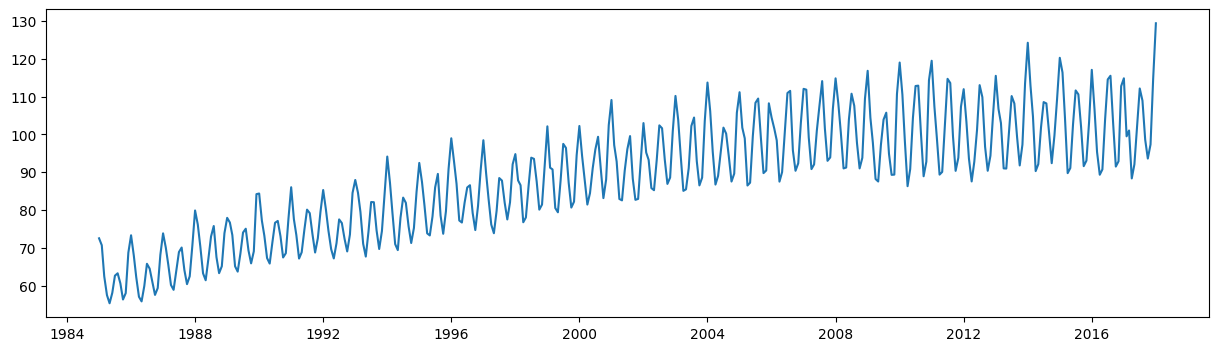

In [7]:
plt.figure(figsize=(15,4))

plt.plot(df.IPG2211A2N)

Text(0.5, 1.0, 'Скользящие статистики')

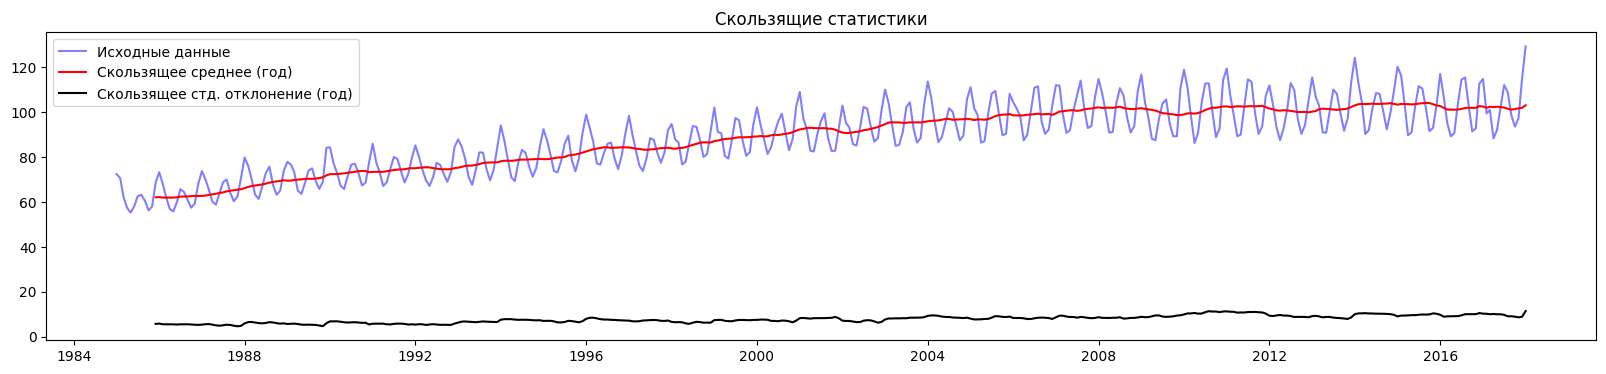

In [8]:
roll_mean = df.IPG2211A2N.rolling(window=12).mean()
roll_std = df.IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(df.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (год)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (год)')
plt.legend(loc='best')
plt.title('Скользящие статистики')

In [10]:
# тест Дикии-Фуллера
dftest = adfuller(df.IPG2211A2N)
print(f'p-value = {dftest[1]},\nstatictic = {dftest[0]}')

p-value = 0.18621469116586592,
statictic = -2.25699035004725


In [12]:
df['log_IPG2211A2N'] = np.log(df.IPG2211A2N + 1e-6)

Text(0.5, 1.0, 'Скользящие статистики (прологарифмированные)')

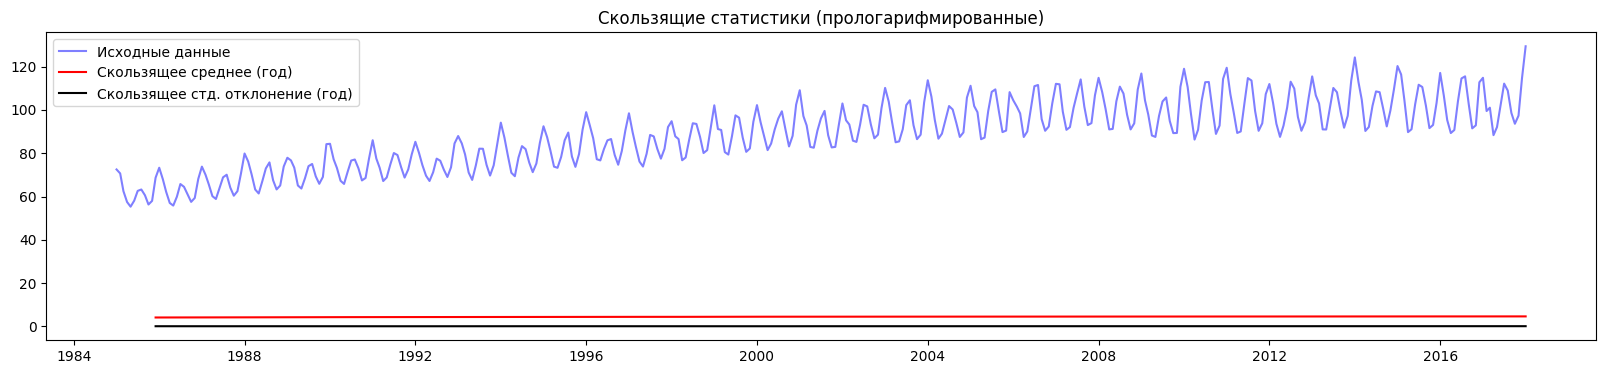

In [13]:
roll_mean = df.log_IPG2211A2N.rolling(window=12).mean()
roll_std = df.log_IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(df.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (год)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (год)')
plt.legend(loc='best')
plt.title('Скользящие статистики (прологарифмированные)')

In [14]:
dftest_log = adfuller(df.log_IPG2211A2N)
print(f'p-value = {dftest_log[1]},\nstatictic = {dftest_log[0]}')

p-value = 0.02337340179331675,
statictic = -3.145360416640745


In [16]:
# разбиение на train & test
test_size = 84  # 7 лет
split_date = df.index[-test_size]

df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

In [ ]:
train_array = df_train.log_IPG2211A2N.values.reshape(-1, 1)  # reshape для создания двумерного массива
test_array = df_test.log_IPG2211A2N.values.reshape(-1, 1)

In [25]:
def create_sequences(data, look_back=12):
    X, Y = [], []
    for i in range(len(data) - look_back):
        sequence = data[i:(i + look_back), 0]
        X.append(sequence)

        target = data[i + look_back, 0]
        Y.append(target)

    return np.array(X), np.array(Y)

In [23]:
scaler = StandardScaler()

train_scaler = scaler.fit_transform(train_array)
test_scaler = scaler.transform(test_array)

In [ ]:
X_train, y_train = create_sequences(train_scaler)
X_test, y_test = create_sequences(test_scaler)

In [53]:
N = 12
n_features = 1

model = Sequential()

model.add(Input(shape=(N, n_features)))
model.add(GRU(
    units=50,
    return_sequences=True  
))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [55]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [56]:
model.fit(
    X_train,
    y_train,
    epochs=50,      
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.5143 - val_loss: 0.4461
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3350 - val_loss: 0.4310
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3104 - val_loss: 0.4287
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3039 - val_loss: 0.4370
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2900 - val_loss: 0.4110
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2797 - val_loss: 0.3866
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2811 - val_loss: 0.3852
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2608 - val_loss: 0.3840
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2608 - val_loss: 0.3584
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2496 - val_loss: 0.3481
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2383 - val_loss: 0.3341
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2277 - val_loss: 0.3191
E

In [57]:
predictions_norm = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [58]:
pred_log = scaler.inverse_transform(predictions_norm)
pred = np.exp(pred_log).flatten()

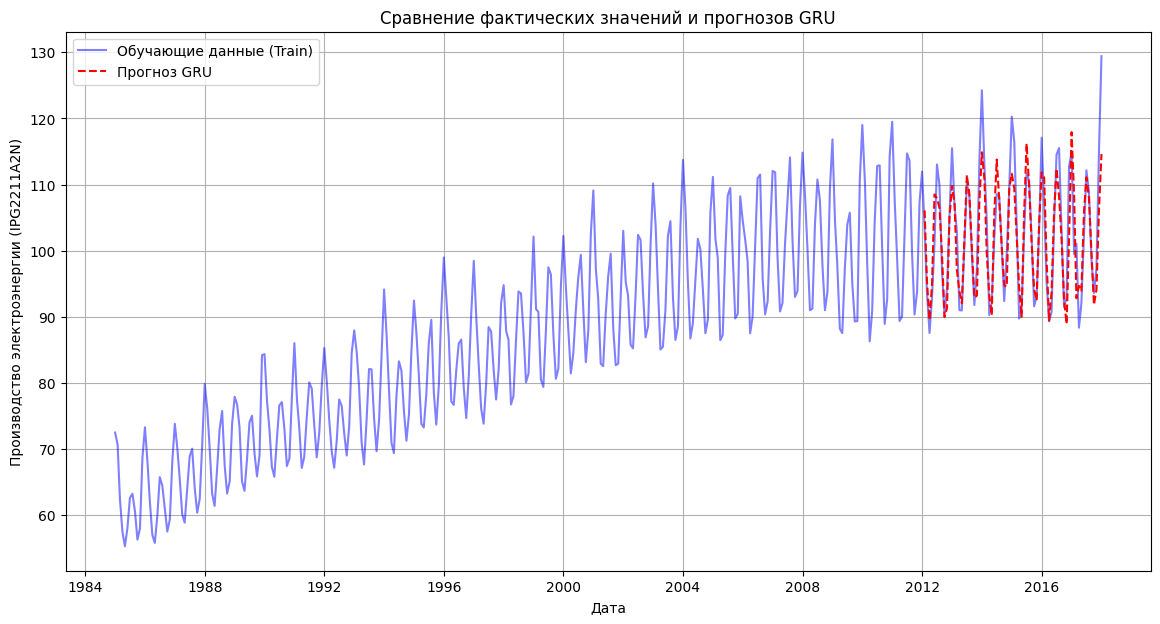

In [59]:
N = 12

start_index = df_test.index[N]
forecast_index = df_test.index[N:]

forecast_series = pd.Series(pred, index=forecast_index)

plt.figure(figsize=(14, 7))

plt.plot(df.index, df.IPG2211A2N, label='Обучающие данные (Train)', color='blue', alpha=0.5)
plt.plot(forecast_series.index, forecast_series, label='Прогноз GRU', color='red', linestyle='--', linewidth=1.5)

plt.title('Сравнение фактических значений и прогнозов GRU')
plt.xlabel('Дата')
plt.ylabel('Производство электроэнергии (IPG2211A2N)')
plt.legend()
plt.grid(True)

_____

In [94]:
model_lstm = Sequential()

model_lstm.add(Input(shape=(N, n_features)))

model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

In [93]:
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [95]:
model_lstm.fit(
    X_train, 
    y_train, 
    epochs=100,       
    batch_size=32,    
    validation_split=0.1, 
    verbose=1,
    shuffle=False,
    callbacks=[early_stop_lstm]
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5122 - val_loss: 0.6635
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3192 - val_loss: 0.4078
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2460 - val_loss: 0.3357
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2641 - val_loss: 0.3361
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2452 - val_loss: 0.3380
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2478 - val_loss: 0.3382
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2366 - val_loss: 0.3319
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2430 - val_loss: 0.3296
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2403 - val_loss: 0.3336
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2435 - val_loss: 0.3273
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2302 - val_loss: 0.3196
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2199 - val_loss: 0.31

In [96]:
predictions_norm_lstm = model_lstm.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


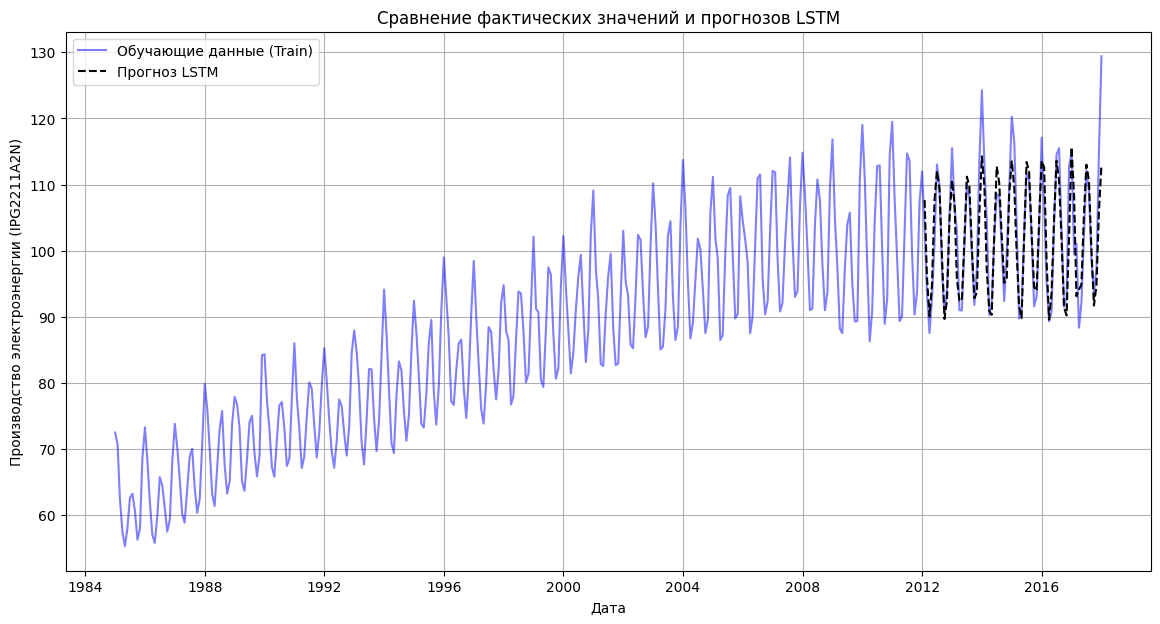

In [97]:
pred_log_restored_lstm = scaler.inverse_transform(predictions_norm_lstm) 
pred_final_lstm = np.exp(pred_log_restored_lstm).flatten()

forecast_index = df_test.index[N:]
forecast_series_lstm = pd.Series(pred_final_lstm, index=forecast_index)

plt.figure(figsize=(14, 7))

plt.plot(df.index, df.IPG2211A2N, label='Обучающие данные (Train)', color='blue', alpha=0.5)
plt.plot(forecast_series_lstm.index, forecast_series_lstm, label='Прогноз LSTM', color='black', linestyle='--', linewidth=1.5)

plt.title('Сравнение фактических значений и прогнозов LSTM')
plt.xlabel('Дата')
plt.ylabel('Производство электроэнергии (IPG2211A2N)')
plt.legend()
plt.grid(True)

___

In [122]:
from scipy.fft import rfft, rfftfreq
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [101]:
dff = pd.read_csv('src/Electric_Production.csv', parse_dates=['DATE'], index_col='DATE')

In [103]:
dff.columns = ['Production']
dff.index.freq = 'MS'

In [108]:
dff['t'] = np.arange(len(dff))

In [116]:
test_months = 24
train_dff = dff.iloc[:-test_months].copy()
test_dff = dff.iloc[-test_months:].copy()

In [117]:
model_trend = LinearRegression()
model_trend.fit(train_dff[['t']], train_dff['Production'])

train_dff['trend'] = model_trend.predict(train_dff[['t']])
train_dff['residuals'] = train_dff['Production'] - train_dff['trend']

In [118]:
n = len(train_dff)
yf = rfft(train_dff['residuals'].values)
xf = rfftfreq(n, 1)

top_n_harmonics = 30
indices = np.argsort(np.abs(yf))[::-1]
top_indices = indices[:top_n_harmonics]

In [120]:
def fourier_predict(t_values, fft_coeffs, frequencies, indices_to_use, n_samples):
    result = np.zeros(len(t_values))
    for idx in indices_to_use:
        amp = np.abs(fft_coeffs[idx]) / n_samples
        if idx != 0: amp *= 2
        phase = np.angle(fft_coeffs[idx])
        freq = frequencies[idx]
        result += amp * np.cos(2 * np.pi * freq * t_values + phase)
    return result

In [121]:
test_trend = model_trend.predict(test_dff[['t']])

test_seasonality = fourier_predict(
    test_dff['t'].values, 
    yf, 
    xf, 
    top_indices, 
    n 
)

test_dff['pred_fourier'] = test_trend + test_seasonality

In [123]:
mae = mean_absolute_error(test_dff['Production'], test_dff['pred_fourier'])
mape = mean_absolute_percentage_error(test_dff['Production'], test_dff['pred_fourier'])

print(f"\nСредняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Ошибка в процентах (MAPE): {mape:.2%}")


Средняя абсолютная ошибка (MAE): 8.89
Ошибка в процентах (MAPE): 8.91%


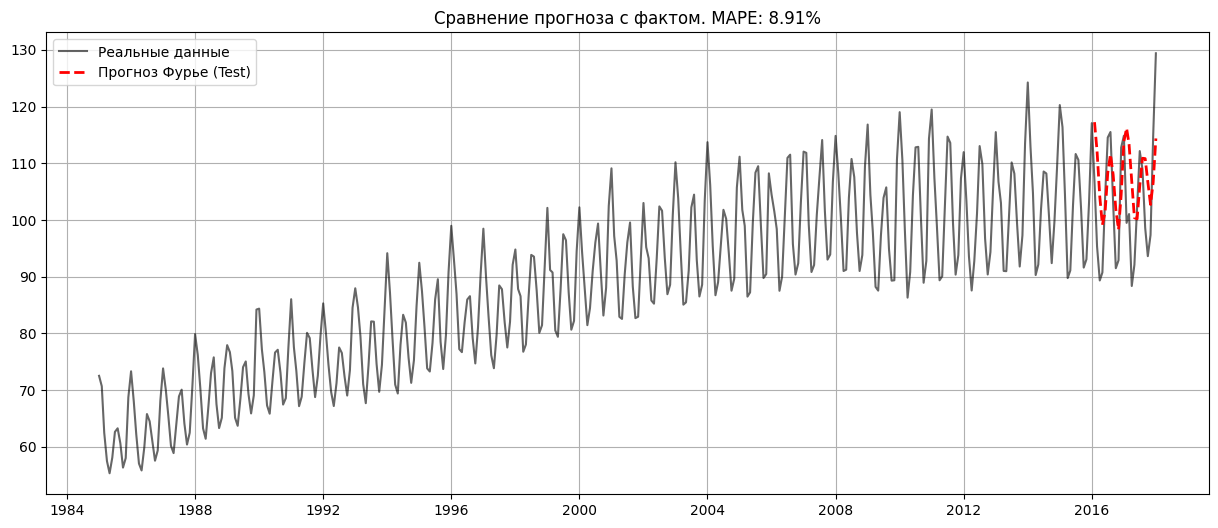

In [127]:
plt.figure(figsize=(15, 6))

plot_start_index = len(dff) - test_months - 48

plt.plot(dff.index, dff['Production'], 
         label='Реальные данные', color='black', alpha=0.6)

plt.plot(test_dff.index, test_dff['pred_fourier'], 
         label='Прогноз Фурье (Test)', color='red', linewidth=2, linestyle='--')

plt.title(f'Сравнение прогноза с фактом. MAPE: {mape:.2%}')
plt.legend()
plt.grid(True)